## E2. KNN

This experiment uses K-Nearest Neighbors to label new student response items.

In [2]:
import spacy
import sys
sys.path.append('../')
from importlib import reload
import libs.ml as ml
import libs.utils as utils
import libs.stats as stats
from importlib import reload
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
df2_en = utils.load_dataframe(language='en',version=2)
nlp_en = spacy.load('en')

In [6]:
from scipy import spatial
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import operator

def cosine_similarity(x,y):
    return 1 - spatial.distance.cosine(x,y)

class KNN:

    def __init__(self, student_response, other_responses, vectorizer, k=3):
        self.student_response = student_response
        self.other_responses = other_responses
        self._vectorizer = vectorizer
        self._k = k

    def score(self):
        vectors = []
        sr = self.student_response
        
        for raw_response, score in self.other_responses:
            vectors.append(raw_response)
        
        self._vectorizer.fit(vectors)
        
        distances = []
        
        for raw_response, score in self.other_responses:
            mat = self._vectorizer.transform([sr, raw_response])
            a = mat.toarray()
            dist = cosine_similarity(a[0], a[1])
            distances.append([dist, score])
            
        sorted_items = sorted(distances, key=lambda x: operator.getitem(x,0), reverse=True)
        #print(sr)
        #print(sorted_items)
        
        
        scores = {}
        index = 0
        while index < self._k and index < len(sorted_items):
            item = sorted_items[index]
            score = item[1]
            if score in scores:
                scores[score] += 1
            else:
                scores[score] = 1
            index += 1
                
        # Best Match
        best_match = float(sorted_items[0][1])
                
        # Most Match
        n = np.max(list(scores.values()))
        most_match = -1
        for key in scores.keys():
            value = scores[key]
            if value == n:
                most_match = float(score)
                break
        
        # if All Matches are equal return the first
        # Otherwise return the most oft occuring match
        if most_match < 0:
            return best_match
        else:
            return most_match
        
        
def preprocess(sent):
    tokens = []
    for t in nlp_en(sent):
        if t.pos_ in ['SPACE', 'PUNCT', 'DET'] or t.is_stop:
            continue
        else:
            prefix = ''
            label = '{}{}'
            
            if 'neg' in [x.dep_ for x in t.children]:
                prefix = 'neg_'
                
            if t.pos_ in ['PRON', 'PROPN']:    
                tokens.append(label.format(prefix,t.text.lower()))
            else:
                tokens.append(label.format(prefix,t.lemma_))
    return tokens
        
def run_model(df, vec):
    y_pred_raw = []
    counter = 0
    for index, row in df.iterrows():
        others = df[np.logical_and(df['Prompt'] == row['Prompt'], df['Student Answer'] != row['Student Answer'])]
        sa = row['Student Answer']
        #print(row['Score'])
        sa_list = others[['Student Answer', 'Score']].as_matrix()
        add_vec = [row['Model Answer'], 5.0]
        sa_list = np.vstack([sa_list, add_vec])
        knn = KNN(sa, sa_list, vec, k=3)
        raw_score = knn.score()
        #print(raw_score)
        y_pred_raw.append(raw_score)

        counter += 1
        if counter % 50 == 0:
            print('batch {}: done.'.format(counter))
            
    return {
        'y_pred' : np.round(y_pred_raw).astype(int),
        'y_pred_raw' : y_pred_raw,
        'y_true' : np.round(df['Score'].as_matrix()).astype(int),
        'y_true_raw' : df['Score'].as_matrix()
    }
        

v = CountVectorizer(tokenizer=preprocess)
results = run_model(df2_en.iloc[:400], v)

batch 50: done.
batch 100: done.
batch 150: done.
batch 200: done.
batch 250: done.
batch 300: done.
batch 350: done.
batch 400: done.


Accuracy: 53.250%
Precision: 50.099%
Recall: 53.250%
F1-Measure: 50.741%
Pearson's R: 0.25
Cohen's Kappa: 0.29
RMSE: 1.50
MAE: 0.87
Y-True Mean: 3.92
Y-Pred Mean: 4.20
Y-True Std Deviation: 1.25
Y-Pred Std Deviation: 1.17


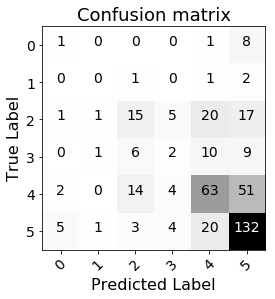

In [7]:
stats.print_big4(results['y_true'], results['y_pred'])
stats.print_stats(results['y_true'], results['y_pred'])
stats.plot_confusion_matrix(stats.cm(results['y_true'], results['y_pred']),classes=np.unique(results['y_true']))

In [8]:
y_true_pf = utils.convert_to_pass_fail(results['y_true'])
y_pred_pf = utils.convert_to_pass_fail(results['y_pred'])

stats.print_big4(y_true_pf, y_pred_pf)
stats.print_stats(y_true_pf, y_pred_pf)
stats.plot_confusion_matrix(stats.cm(y_true_pf, y_pred_pf),classes=np.unique(y_true_pf))

Accuracy: 78.500%
Precision: 75.900%
Recall: 78.500%
F1-Measure: 76.943%
Pearson's R: 0.19
Cohen's Kappa: 0.18
RMSE: 0.46
MAE: 0.21
Y-True Mean: 0.82
Y-Pred Mean: 0.87
Y-True Std Deviation: 0.39
Y-Pred Std Deviation: 0.33
